A base utilizada neste projeto contém informações financeiras, comportamentais e históricas de crédito dos clientes. Abaixo, um resumo das principais colunas:

| Coluna                    | Descrição                                                         |
|---------------------------|-------------------------------------------------------------------|
| ID                        | Identificador único do registro                                   |
| Customer_ID               | Identificador do cliente                                          |
| Month                     | Mês de referência da transação                                    |
| Name                      | Nome do cliente                                                   |
| Age                       | Idade do cliente                                                  |
| SSN                       | Número de segurança social (formato com caracteres especiais)     |
| Occupation                | Profissão do cliente                                              |
| Annual_Income             | Renda anual                                                       |
| Monthly_Inhand_Salary     | Salário mensal disponível                                         |
| Num_Bank_Accounts         | Número de contas bancárias                                        |
| Num_Credit_Card           | Número de cartões de crédito                                      |
| Interest_Rate             | Taxa de juros                                                     |
| Num_of_Loan               | Quantidade de empréstimos ativos                                  |
| Type_of_Loan              | Tipos de empréstimos (texto com múltiplos valores)                |
| Delay_from_due_date       | Dias de atraso no pagamento                                       |
| Num_of_Delayed_Payment    | Número de pagamentos atrasados                                    |
| Changed_Credit_Limit      | Alteração no limite de crédito                                    |
| Num_Credit_Inquiries      | Número de consultas de crédito                                    |
| Credit_Mix                | Tipo de crédito utilizado (ruim, padrão, bom)                     |
| Outstanding_Debt          | Dívida pendente                                                   |
| Credit_Utilization_Ratio  | Percentual de utilização do limite de crédito                     |
| Credit_History_Age        | Tempo de histórico de crédito                                     |
| Payment_of_Min_Amount     | Se o pagamento mínimo foi realizado                               |
| Payment_Behaviour         | Comportamento de pagamento                                        |
| Monthly_Balance           | Saldo médio mensal                                                |
| Amount_invested_monthly   | Valor investido mensalmente                                       |
| Credit_Score              | Classificação do crédito (ruim, padrão, bom)                      |


In [1]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
# import missingno
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Pre-Processing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Model relavant libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.saving import save_model
from keras.optimizers import Adam
from keras.regularizers import l2

In [2]:
# Load dataset
df_total = pd.read_csv('client.csv')

In [3]:
# Funções

# Informações da coluna
def object_summary(df):
    obs = df.shape[0]

    object_df = df.select_dtypes(include='object')
    summary_df = pd.DataFrame({
        'Dtype': object_df.dtypes,
        'Counts': object_df.apply(lambda x: x.count()),
        'Nulls': object_df.apply(lambda x: x.isnull().sum()),
        'NullPercent': (object_df.isnull().sum() / obs) * 100,
        'Top': object_df.apply(lambda x: x.mode()[0] if not x.mode().empty else '-'),
        'Frequency': object_df.apply(lambda x: x.value_counts().max() if not x.value_counts().empty else '-'),
        'Uniques': object_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': object_df.apply(lambda x: list(x.unique()) if x.nunique() <= 20 else '-')
    })

    # Adequação das porcentagens
    summary_df['NullPercent'] = summary_df['NullPercent'].map("{:.2f}%".format)

    print('Informações da coluna:')
    print('___________________________\nTipos de dados:')
    print(summary_df['Dtype'].value_counts())
    print('___________________________')

    return summary_df


# Informações das colunas numericas
def numeric_summary(df):
    obs = df.shape[0]

    numeric_df = df.select_dtypes(include='number')
    summary_df = pd.DataFrame({
        'Dtype': numeric_df.dtypes,
        'Counts': numeric_df.apply(lambda x: x.count()),
        'Nulls': numeric_df.apply(lambda x: x.isnull().sum()),
        'NullPercent': (numeric_df.isnull().sum() / obs) * 100,
        'Min': numeric_df.min(),
        'Max': numeric_df.max(),
        'Uniques': numeric_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': numeric_df.apply(lambda x: list(x.unique()) if x.nunique() <= 20 else '-')
    })

    # Adequação das porcentagens
    summary_df['NullPercent'] = summary_df['NullPercent'].map("{:.2f}%".format)

    print('Informações das colunas numéricas:')
    print('___________________________\nData Types:')
    print(summary_df['Dtype'].value_counts())
    print('___________________________')

    return summary_df


# Contagem de valores por coluna
def get_value_count(df, column_name):
    """
    This function calculates and returns a DataFrame with the value counts and
    their corresponding percentages for a specified column in the DataFrame.
    """

    vc = df[column_name].value_counts()
    vc_norm = df[column_name].value_counts(normalize=True)

    vc = vc.rename_axis(column_name).reset_index(name='counts')
    vc_norm = vc_norm.rename_axis(column_name).reset_index(name='percent')
    vc_norm['percent'] = (vc_norm['percent'] * 100).map('{:.2f}%'.format)

    df_result = pd.concat([vc[column_name], vc['counts'], vc_norm['percent']], axis=1)

    return df_result



# Identifica valores nulos
def missing_values(df):

    missing_count = df.isnull().sum()
    value_count = df.isnull().count()
    missing_percentage = round(missing_count / value_count * 100, 2)

    # Format the percentage as '0.00%' with % symbol
    missing_percentage_formatted = missing_percentage.map("{:.2f}%".format)
    # Create a DataFrame to store the results
    missing_df = pd.DataFrame({"count": missing_count, "percentage": missing_percentage_formatted})

    return missing_df


# grafico dos valores nulos
def na_ratio_plot(df):

    sns.displot(df.isna().melt(value_name='Missing_data',var_name='Features')\
                ,y='Features',hue='Missing_data',multiple='fill',aspect=9/8)

    print(df.isna().sum()[df.isna().sum()>0])


import re
# identifica valores não numericos em colunas numericas
def find_non_numeric_values(df, column_name):

    pattern = r'\D+'  # Pattern to match non-numeric characters
    # Find and flatten non-numeric values, then ensure uniqueness with set
    return set(re.findall(pattern, ' '.join(df[column_name].astype(str))))


from sklearn.impute import KNNImputer

def knn_impute_column(df, column, n_neighbors=5):
    """
    Coloca valores nas células faltantes usando o KNN.
    Args: df (DataFrame), column (str), n_neighbors (int): Number of neighbors (Default is 5).
    Returns: DataFrame: DataFrame with imputed column.
    """
    # Apply KNN imputation to the specified column
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[[column]] = imputer.fit_transform(df[[column]])

    return df


def history_age_month(age):
    """
    Converte a idade em meses
    """
    try:
        # extrai os anos
        years = int(re.findall(r'\d+', age.split("and")[0])[0])

        # extrai os meses
        months = int(re.findall(r'\d+', age.split("and")[1])[0])

        # converte os anos em meses e soma com os meses extraidos
        return int(years * 12 + months)

    except (IndexError, ValueError, AttributeError):
        # retorna NaN caso erro
        return np.nan


def padronizar(df, id_col, target_col):
    # Calcular a moda (valor mais frequente) por id_col
    moda = (
        df.groupby(id_col)[target_col]
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
        .reset_index()
        .rename(columns={target_col: "moda"})
    )

    # Juntar com o dataframe original
    df_corrigido = df.merge(moda, on=id_col, how="left")

    # Substituir valores diferentes da moda
    df_corrigido[target_col] = df_corrigido.apply(
        lambda row: row["moda"] if pd.notna(row["moda"]) and row[target_col] != row["moda"] else row[target_col],
        axis=1
    )

    # Remover a coluna auxiliar
    df_corrigido.drop(columns=["moda"], inplace=True)

    return df_corrigido

In [4]:
df_total.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,...,_,809.98,26.823,22 Years and 1 Months,No,49.575,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.945,NaN,No,49.575,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609,22 Years and 3 Months,No,49.575,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.378,22 Years and 4 Months,No,49.575,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,...,Good,809.98,24.797,22 Years and 5 Months,No,49.575,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [6]:
print(f'Shape:  {df_total.shape}')
print(f'LInhas duplicadas: {df_total.duplicated().sum()}')
print(f'Null: {df_total.isnull().sum()}')

Shape:  (100000, 28)
LInhas duplicadas: 0
Null: ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0


In [7]:
object_summary(df_total)

Informações da coluna:
___________________________
Tipos de dados:
Dtype
object    20
Name: count, dtype: int64
___________________________


,Dtype,Counts,Nulls,NullPercent,Top,Frequency,Uniques,UniqueValues
ID,object,100000,0,0.00%,0x10002,1,100000,-
Customer_ID,object,100000,0,0.00%,CUS_0x1000,8,12500,-
Month,object,100000,0,0.00%,April,12500,8,"[January, February, March, April, May, June, J..."
Name,object,90015,9985,9.98%,Langep,44,10140,-
Age,object,100000,0,0.00%,38,2833,1788,-
SSN,object,100000,0,0.00%,#F%$D@*&8,5572,12501,-
Occupation,object,100000,0,0.00%,_______,7062,16,"[Scientist, _______, Teacher, Engineer, Entrep..."
Annual_Income,object,100000,0,0.00%,17273.83,16,18940,-
Num_of_Loan,object,100000,0,0.00%,3,14386,434,-
Type_of_Loan,object,88592,11408,11.41%,Not Specified,1408,6261,-


In [8]:
numeric_summary(df_total)

Informações das colunas numéricas:
___________________________
Data Types:
Dtype
float64    4
int64      4
Name: count, dtype: int64
___________________________


,Dtype,Counts,Nulls,NullPercent,Min,Max,Uniques,UniqueValues
Monthly_Inhand_Salary,float64,84998,15002,15.00%,303.645,15204.633,13236,-
Num_Bank_Accounts,int64,100000,0,0.00%,-1.000,1798.000,943,-
Num_Credit_Card,int64,100000,0,0.00%,0.000,1499.000,1179,-
Interest_Rate,int64,100000,0,0.00%,1.000,5797.000,1750,-
Delay_from_due_date,int64,100000,0,0.00%,-5.000,67.000,73,-
Num_Credit_Inquiries,float64,98035,1965,1.97%,0.000,2597.000,1224,-
Credit_Utilization_Ratio,float64,100000,0,0.00%,20.000,50.000,100000,-
Total_EMI_per_month,float64,100000,0,0.00%,0.000,82331.000,14950,-


As colunas de identificação (ID, Customer_ID, Name, SSN) não são diretamente úteis em tarefas de classificação e podem aumentar a complexidade do modelo em vez de melhorar seu desempenho.
Portanto, essas colunas serão descartadas ao final da etapa de limpeza dos dados.

In [9]:
# Coluna Annual_Income
find_non_numeric_values(df_total, 'Annual_Income')

# Remove os caracteres não numericos de 'Annual_Income'
df_total['Annual_Income'] = df_total['Annual_Income'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x)))

# Converte a coluna em float
df_total['Annual_Income'] = df_total['Annual_Income'].astype(float)

# Verificação após ajuste
print("Após ajuste")
find_non_numeric_values(df_total, 'Annual_Income')

Após ajuste


{' ', '.'}

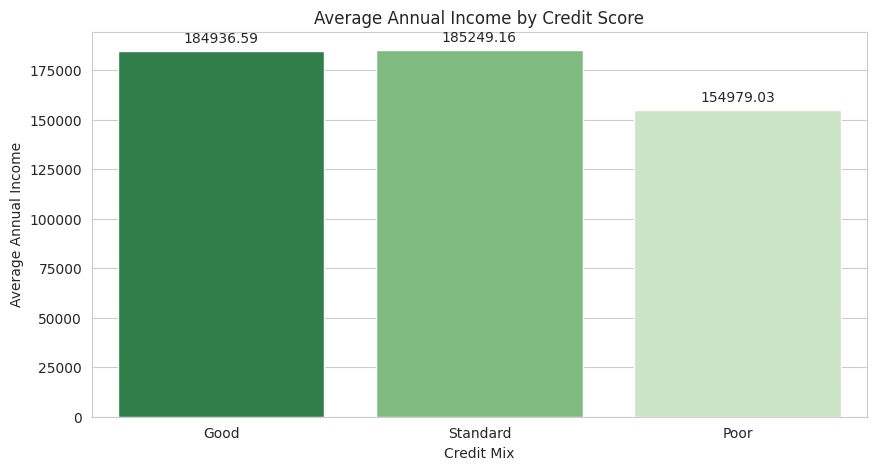

In [10]:
# Gráfico do Annual_Income por Credit_Score

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Credit_Score', y='Annual_Income', data=df_total, ci=None, palette='Greens_r')

for p in ax.patches: ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

plt.title('Average Annual Income by Credit Score')
plt.xlabel('Credit Mix')
plt.ylabel('Average Annual Income')

plt.show()

In [11]:
# Coluna Monthly_Inhand_Salary

get_value_count(df_total, 'Monthly_Inhand_Salary')

,Monthly_Inhand_Salary,counts,percent
0,2295.058,15,0.02%
1,6082.188,15,0.02%
2,6358.957,15,0.02%
3,6769.130,15,0.02%
4,3080.555,14,0.02%
...,...,...,...
13230,3415.782,1,0.00%
13231,6272.739,1,0.00%
13232,1069.950,1,0.00%
13233,454.382,1,0.00%


In [12]:
find_non_numeric_values(df_total, 'Monthly_Inhand_Salary')

{' ',
 ' nan ',
 ' nan nan ',
 ' nan nan nan ',
 ' nan nan nan nan ',
 ' nan nan nan nan nan ',
 '.'}

In [13]:
# seleciona as colunas numéricas
numeric_columns = df_total.select_dtypes(include=[np.number])

# calculamos a matriz de correlação
df_corr = numeric_columns.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr[df_corr['level_0'] == 'Monthly_Inhand_Salary'].head()

,level_0,level_1,0
1,Monthly_Inhand_Salary,Monthly_Inhand_Salary,1.000
10,Monthly_Inhand_Salary,Delay_from_due_date,0.250
11,Monthly_Inhand_Salary,Credit_Utilization_Ratio,0.173
15,Monthly_Inhand_Salary,Annual_Income,0.031
21,Monthly_Inhand_Salary,Num_Bank_Accounts,0.011


In [14]:
# limpa os valores nulos com o calculo da média do "Annual_Income"
df_total['Monthly_Inhand_Salary'].fillna(df_total['Annual_Income'] / 12, inplace=True)

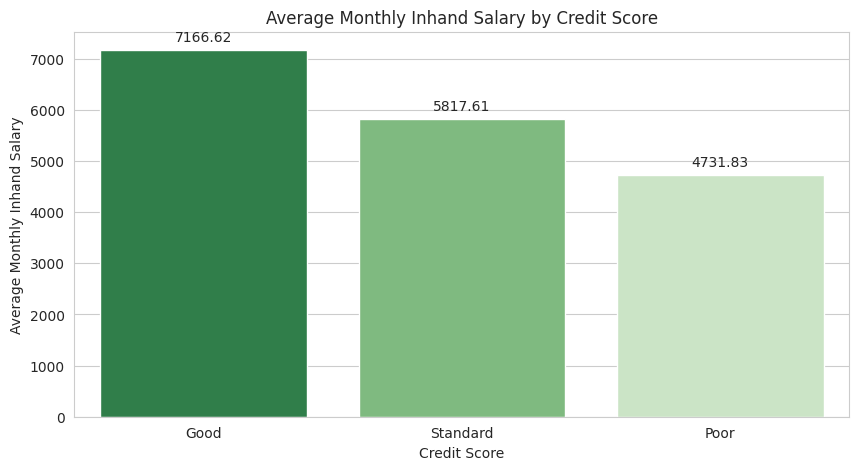

In [15]:
# gráfico do Monthly_Inhand_Salary por Credit_Score
plt.figure(figsize=(10, 5))
ax=sns.barplot(x='Credit_Score', y='Monthly_Inhand_Salary', data=df_total, ci=None, palette='Greens_r')

for p in ax.patches:  ax.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9), textcoords='offset points')

plt.title('Average Monthly Inhand Salary by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Monthly Inhand Salary')

plt.show()

In [16]:
# Coluna Type_of_Loan

"""
A coluna "Type_of_Loan" foi transformada para separar vários tipos de empréstimo em colunas binárias individuais (0 e 1).
Cada nova coluna indica se um tipo específico de empréstimo está presente naquela linha.
Isso ajuda o modelo a entender melhor os diferentes tipos de empréstimo.
Os valores "Verdadeiro/Falso" foram convertidos para 0/1, e a coluna "Type_of_Loan" original foi excluída.
"""

get_value_count(df_total, 'Type_of_Loan')

,Type_of_Loan,counts,percent
0,Not Specified,1408,1.59%
1,Credit-Builder Loan,1280,1.44%
2,Personal Loan,1272,1.44%
3,Debt Consolidation Loan,1264,1.43%
4,Student Loan,1240,1.40%
...,...,...,...
6255,"Debt Consolidation Loan, Personal Loan, Mortga...",8,0.01%
6256,"Student Loan, Home Equity Loan, Student Loan, ...",8,0.01%
6257,"Not Specified, Auto Loan, Auto Loan, and Debt ...",8,0.01%
6258,"Credit-Builder Loan, Auto Loan, Mortgage Loan,...",8,0.01%


In [17]:
# Visualizar os valores únicos, realizando o split separando por vírgulas
unique_loan = df_total['Type_of_Loan'].dropna().str.split(',').explode().str.strip().unique()
unique_loan = [loan.replace('and ', '').strip() for loan in unique_loan]
unique_loan

['Auto Loan',
 'Credit-Builder Loan',
 'Personal Loan',
 'Home Equity Loan',
 'Not Specified',
 'Not Specified',
 'Mortgage Loan',
 'Student Loan',
 'Debt Consolidation Loan',
 'Auto Loan',
 'Payday Loan',
 'Payday Loan',
 'Student Loan',
 'Personal Loan',
 'Home Equity Loan',
 'Mortgage Loan',
 'Debt Consolidation Loan',
 'Credit-Builder Loan']

In [18]:
# For com a coluna alvo, excluindo o cabeçalho
for i in df_total['Type_of_Loan'].value_counts().head(9).index[1:]:
    # cria a coluna no dataset
    # se o valor existir na coluna antiga a coluna nova recebe 1 caso não 0
    df_total[i] = df_total['Type_of_Loan'].str.contains(i, na=False).astype(int)

# Exclui a coluna original
del df_total['Type_of_Loan']

df_total.head(3)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,312.49408867943663,Good,1,1,0,0,0,0,1,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,284.62916249607184,Good,1,1,0,0,0,0,1,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.120,1592.843,3,...,331.2098628537912,Good,1,1,0,0,0,0,1,1


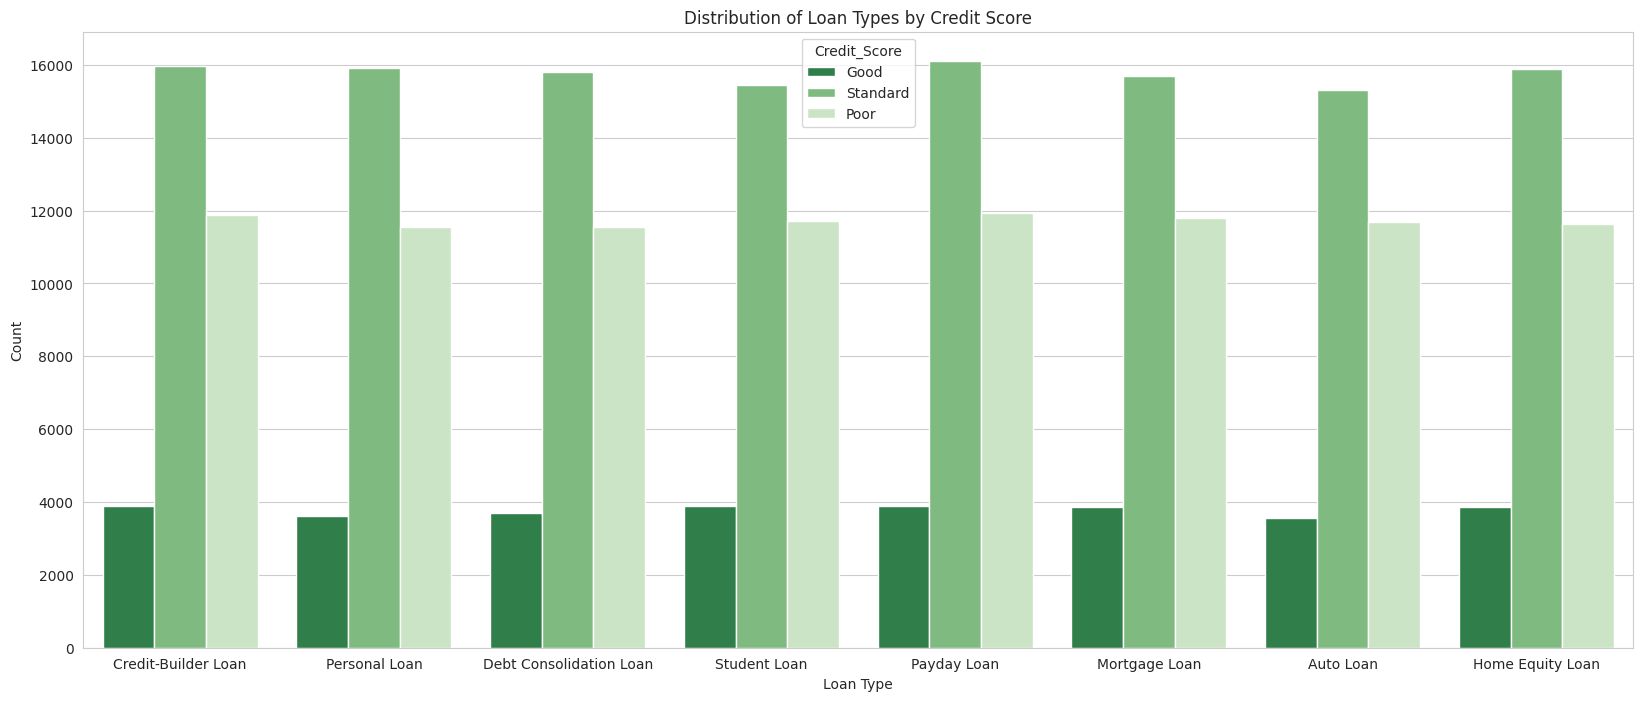

In [19]:
# Grafico sobre Loan Types por Credit Score

loan_columns = ['Credit-Builder Loan', 'Personal Loan', 'Debt Consolidation Loan', 'Student Loan',
                'Payday Loan', 'Mortgage Loan', 'Auto Loan', 'Home Equity Loan']

df_melted = df_total.melt(id_vars='Credit_Score', value_vars=loan_columns,
                       var_name='Loan Type', value_name='Has Loan')

plt.figure(figsize=(20,8))
sns.countplot(x='Loan Type', hue='Credit_Score', data=df_melted[df_melted['Has Loan'] == 1], palette='Greens_r')

plt.title('Distribution of Loan Types by Credit Score')
plt.xlabel('Loan Type')
plt.ylabel('Count')

plt.show()

In [20]:
# Coluna Num_of_Delayed_Payment
get_value_count(df_total, 'Num_of_Delayed_Payment')

,Num_of_Delayed_Payment,counts,percent
0,19,5327,5.73%
1,17,5261,5.66%
2,16,5173,5.56%
3,10,5153,5.54%
4,18,5083,5.47%
...,...,...,...
744,3845,1,0.00%
745,4075,1,0.00%
746,1502,1,0.00%
747,1530,1,0.00%


In [21]:
find_non_numeric_values(df_total, 'Num_of_Delayed_Payment')

{' ',
 ' -',
 ' nan ',
 ' nan -',
 ' nan nan ',
 ' nan nan -',
 ' nan nan nan ',
 ' nan nan nan -',
 ' nan nan nan nan ',
 ' nan nan nan nan nan ',
 '_ ',
 '_ -',
 '_ nan ',
 '_ nan -',
 '_ nan nan '}

In [22]:
# remove os caracteres não numéricos
df_total['Num_of_Delayed_Payment'] = df_total['Num_of_Delayed_Payment'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x)))
# substitui os valores nulos por NaN
df_total['Num_of_Delayed_Payment'].replace('', np.nan, inplace=True)

# converte o dataset para float
df_total['Num_of_Delayed_Payment'] = df_total['Num_of_Delayed_Payment'].astype(float)

# converte os valores negativos para positivos
df_total['Num_of_Delayed_Payment'] = df_total['Num_of_Delayed_Payment'].abs()

In [23]:
# aplica o KNN na coluna
knn_impute_column(df_total, 'Num_of_Delayed_Payment')

# verifica se há valores nulos
print('Nulos: ', df_total['Num_of_Delayed_Payment'].isna().sum())

Nulos:  0


In [24]:
# Coluna Num_Credit_Inquiries
get_value_count(df_total, 'Num_Credit_Inquiries')

,Num_Credit_Inquiries,counts,percent
0,4.000,11271,11.50%
1,3.000,8890,9.07%
2,6.000,8111,8.27%
3,7.000,8058,8.22%
4,2.000,8028,8.19%
...,...,...,...
1218,1618.000,1,0.00%
1219,758.000,1,0.00%
1220,735.000,1,0.00%
1221,2483.000,1,0.00%


In [25]:
find_non_numeric_values(df_total, 'Num_Credit_Inquiries')

{' ', ' nan ', ' nan nan ', ' nan nan nan ', '.'}

In [26]:
knn_impute_column(df_total, 'Num_Credit_Inquiries')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,312.49408867943663,Good,1,1,0,0,0,0,1,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,284.62916249607184,Good,1,1,0,0,0,0,1,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.120,1592.843,3,...,331.2098628537912,Good,1,1,0,0,0,0,1,1
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,223.45130972736786,Good,1,1,0,0,0,0,1,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,341.48923103222177,Good,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,479.866,Poor,0,0,0,1,0,0,1,0
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,496.652,Poor,0,0,0,1,0,0,1,0
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,516.809,Poor,0,0,0,1,0,0,1,0
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,319.165,Standard,0,0,0,1,0,0,1,0


In [27]:
# verifica valores nulos
print('Nulos:', df_total['Num_Credit_Inquiries'].isna().sum())

Nulos: 0


In [28]:
# Coluna Credit_History_Age
get_value_count(df_total, 'Credit_History_Age')

,Credit_History_Age,counts,percent
0,15 Years and 11 Months,446,0.49%
1,19 Years and 4 Months,445,0.49%
2,19 Years and 5 Months,444,0.49%
3,17 Years and 11 Months,443,0.49%
4,19 Years and 3 Months,441,0.48%
...,...,...,...
399,0 Years and 3 Months,20,0.02%
400,0 Years and 2 Months,15,0.02%
401,33 Years and 7 Months,14,0.02%
402,33 Years and 8 Months,12,0.01%


In [29]:
find_non_numeric_values(df_total, 'Credit_History_Age')

{' Months',
 ' Months ',
 ' Months nan ',
 ' Months nan nan ',
 ' Months nan nan nan ',
 ' Months nan nan nan nan ',
 ' Months nan nan nan nan nan ',
 ' Years and '}

In [30]:
# aplicar a função para transformar os dados em string para numéricos
df_total['Credit_History_Age'] = df_total['Credit_History_Age'].apply(history_age_month)

In [31]:
# aplicar o KNN para substituir os nulos
knn_impute_column(df_total, 'Credit_History_Age')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,312.49408867943663,Good,1,1,0,0,0,0,1,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,284.62916249607184,Good,1,1,0,0,0,0,1,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.120,1592.843,3,...,331.2098628537912,Good,1,1,0,0,0,0,1,1
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,223.45130972736786,Good,1,1,0,0,0,0,1,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,341.48923103222177,Good,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,479.866,Poor,0,0,0,1,0,0,1,0
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,496.652,Poor,0,0,0,1,0,0,1,0
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,516.809,Poor,0,0,0,1,0,0,1,0
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,319.165,Standard,0,0,0,1,0,0,1,0


In [32]:
# verifica valores nulos
print('Nulos:', df_total['Credit_History_Age'].isna().sum())

Nulos: 0


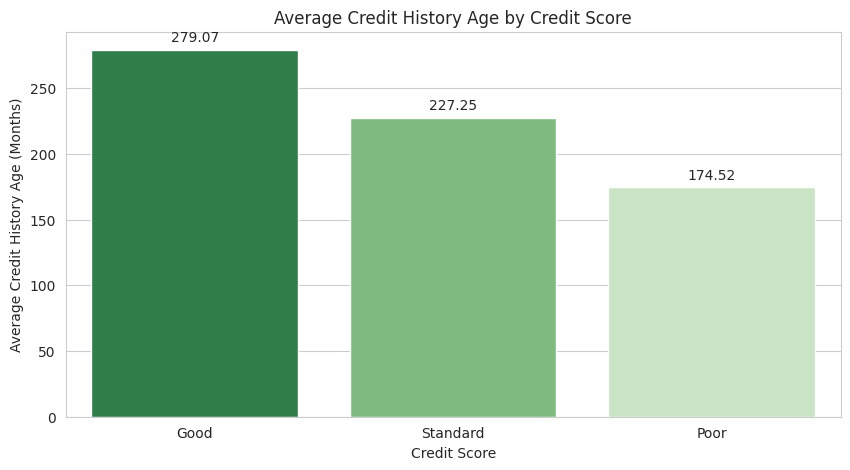

In [33]:
# Gráfico do Credit_History_Age por Credit_Score
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Credit_Score', y='Credit_History_Age', data=df_total, ci=None, palette='Greens_r')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points')

plt.title('Average Credit History Age by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Credit History Age (Months)')

plt.show()

In [34]:
# Coluna Amount_invested_monthly
get_value_count(df_total, 'Amount_invested_monthly')

,Amount_invested_monthly,counts,percent
0,__10000__,4305,4.51%
1,0.0,169,0.18%
2,59.93725850034815,1,0.00%
3,165.180659491917,1,0.00%
4,62.030802602004044,1,0.00%
...,...,...,...
91044,109.296681189146,1,0.00%
91045,33.6098814431885,1,0.00%
91046,76.87001005130772,1,0.00%
91047,908.6939096189257,1,0.00%


In [35]:
find_non_numeric_values(df_total, 'Amount_invested_monthly')

{' ',
 ' __',
 ' nan ',
 ' nan __',
 ' nan nan ',
 ' nan nan __',
 ' nan nan nan ',
 ' nan nan nan nan ',
 '.',
 '__ ',
 '__ __',
 '__ nan ',
 '__ nan __',
 '__ nan nan ',
 '__ nan nan __'}

In [36]:
# remove os carateres não numericos
df_total['Amount_invested_monthly'] = df_total['Amount_invested_monthly'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x)))
df_total['Amount_invested_monthly'].replace('', np.nan, inplace=True)

# converte o dataset para float
df_total['Amount_invested_monthly'] = df_total['Amount_invested_monthly'].astype(float)

# substitui os valores negativos
df_total['Amount_invested_monthly'] = df_total['Amount_invested_monthly'].abs()

In [37]:
# aplicar o KNN
knn_impute_column(df_total, 'Amount_invested_monthly') # Train

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,312.49408867943663,Good,1,1,0,0,0,0,1,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,284.62916249607184,Good,1,1,0,0,0,0,1,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.120,1592.843,3,...,331.2098628537912,Good,1,1,0,0,0,0,1,1
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,223.45130972736786,Good,1,1,0,0,0,0,1,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,341.48923103222177,Good,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,479.866,Poor,0,0,0,1,0,0,1,0
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,496.652,Poor,0,0,0,1,0,0,1,0
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,516.809,Poor,0,0,0,1,0,0,1,0
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,319.165,Standard,0,0,0,1,0,0,1,0


In [38]:
# verifica valores nulos
print('Nulos:', df_total['Amount_invested_monthly'].isna().sum())

Nulos: 0


In [39]:
# Coluna Monthly_Balance
get_value_count(df_total, 'Monthly_Balance')

,Monthly_Balance,counts,percent
0,__-333333333333333333333333333__,9,0.01%
1,252.08489793906085,1,0.00%
2,254.9709216273975,1,0.00%
3,250.0931678204641,1,0.00%
4,289.7550752754317,1,0.00%
...,...,...,...
98787,278.8720257394474,1,0.00%
98788,376.7024623690405,1,0.00%
98789,321.2336043357731,1,0.00%
98790,373.29270287694055,1,0.00%


In [40]:
# Vamos descartar o primeiro dado
df_total['Monthly_Balance'].replace('__-333333333333333333333333333__',np.nan,inplace=True)

In [41]:
find_non_numeric_values(df_total, 'Monthly_Balance')

{' ', ' nan ', ' nan nan ', ' nan nan nan ', ' nan nan nan nan ', '.'}

In [42]:
# converte de hexadecimal para decimal
df_total['Monthly_Balance'] = df_total['Monthly_Balance'].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)

# remmove os caracteres não numéricos
df_total['Monthly_Balance'] = df_total['Monthly_Balance'].apply(lambda x: re.sub(r'[^0-9.]+', '', str(x)))

# substiutui os nulos pos NaN
df_total['Monthly_Balance'].replace('', np.nan, inplace=True)

# converte o dataset para float
df_total['Monthly_Balance'] = pd.to_numeric(df_total['Monthly_Balance'], errors='coerce')

In [43]:
# Seleciona as colunas numéricas
numeric_columns = df_total.select_dtypes(include=[np.number])

# Calcula a correção
df_corr = numeric_columns.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr[df_corr['level_0'] == 'Monthly_Balance'].head()

,level_0,level_1,0
9,Monthly_Balance,Monthly_Balance,1.000
26,Monthly_Balance,Credit_History_Age,0.310
28,Monthly_Balance,Delay_from_due_date,0.279
29,Monthly_Balance,Credit_Utilization_Ratio,0.251
61,Monthly_Balance,Credit-Builder Loan,0.187


In [44]:
# verifica valores nulos
print('Nulos:', df_total['Monthly_Balance'].isna().sum())

Nulos: 1209


In [45]:
"""
A coluna Delay_from_due_date representa quantos dias o cliente atrasou o pagamento após a data de vencimento.
Esse recurso pode estar relacionado ao Monthly_Balance, pois atrasos consistentes nos pagamentos podem refletir estresse financeiro
ou má gestão do fluxo de caixa, o que pode resultar em um saldo mensal menor.
Aqui usamos um agrupamento da coluna Delay_from_due_date para completar a outra.
"""
df_total['Monthly_Balance'] = df_total.groupby('Delay_from_due_date')['Credit_History_Age'].transform(lambda x: x.fillna(x.mean()))

In [46]:
# verifica valores nulos
print('Nulos:', df_total['Monthly_Balance'].isna().sum())

Nulos: 0


In [47]:
# Coluna Month
get_value_count(df_total, 'Month')

,Month,counts,percent
0,January,12500,12.50%
1,February,12500,12.50%
2,March,12500,12.50%
3,April,12500,12.50%
4,May,12500,12.50%
5,June,12500,12.50%
6,July,12500,12.50%
7,August,12500,12.50%


In [48]:
# verifica valores nulos
print('Nulos:', df_total['Month'].isna().sum())

Nulos: 0


In [49]:
# Coluna Age
get_value_count(df_total, 'Age')

,Age,counts,percent
0,38,2833,2.83%
1,28,2829,2.83%
2,31,2806,2.81%
3,26,2792,2.79%
4,32,2749,2.75%
...,...,...,...
1783,6618,1,0.00%
1784,3155,1,0.00%
1785,5063,1,0.00%
1786,2875,1,0.00%


In [50]:
# verifica valores nulos
print('Nulos:', df_total['Age'].isna().sum())

find_non_numeric_values(df_total, 'Age')

Nulos: 0


{' ', ' -', '_ ', '_ -'}

In [51]:
#  Remove caracteres não numericos
df_total['Age'] = df_total['Age'].apply(lambda x: re.sub(r'[^0-9.]+', '', str(x)))

# Converte o Dataset para float
df_total['Age'] = pd.to_numeric(df_total['Age'], errors='coerce')

In [52]:
# Padronizar a coluna
padronizar(df_total, "Customer_ID", "Age")

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,265.000,Good,1,1,0,0,0,0,1,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,221.195,Good,1,1,0,0,0,0,1,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,267.000,Good,1,1,0,0,0,0,1,1
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1592.843,3,...,268.000,Good,1,1,0,0,0,0,1,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,3,...,269.000,Good,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,378.000,Poor,0,0,0,1,0,0,1,0
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,379.000,Poor,0,0,0,1,0,0,1,0
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,380.000,Poor,0,0,0,1,0,0,1,0
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.990,3359.416,4,...,381.000,Standard,0,0,0,1,0,0,1,0


Para este conjunto de dados específico, considerando que se concentra em atividades financeiras como empréstimos, crédito e outros serviços bancários, um limite de idade razoável poderia ser em torno de 65-70 anos. Isso está em linha com as práticas gerais do setor financeiro, onde bancos e instituições financeiras tendem a ser mais cautelosos ao emprestar para indivíduos que estão se aproximando ou já ultrapassaram a idade típica de aposentadoria.
Valores de idade abaixo de 18 anos também devem ser considerados irrealistas para a maioria dos tipos de empréstimos, visto que as pessoas geralmente começam a tomar empréstimos após atingirem a maioridade legal.

In [53]:
# Substitui os valores irreais da coluna Age
df_total.loc[(df_total['Age'] > 70) | (df_total['Age'] < 18), 'Age'] = np.nan

In [54]:
df_total['Age'].describe()

,Age
count,91513.000
mean,34.426
std,10.114
min,18.000
25%,26.000
50%,34.000
75%,42.000
max,56.000


In [55]:
# verifica valores nulos
print('Nulos:', df_total['Age'].isna().sum())

Nulos: 8487


In [56]:
# seleciona apenas as colunas numéricas
numeric_columns = df_total.select_dtypes(include=[np.number])
# calcula a matrix de correlação
df_corr = numeric_columns.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
# filtra os valores
df_corr[df_corr['level_0'] == 'Age'].head()

,level_0,level_1,0
10,Age,Age,1.000
78,Age,Credit_History_Age,0.178
79,Age,Monthly_Balance,0.178
83,Age,Delay_from_due_date,0.138
94,Age,Personal Loan,0.084


In [57]:
# Substitui os valores faltantes pela média da coluna Age agrupados pelas colunas: 'Credit_History_Age', 'Delay_from_due_date'
df_total['Age'] = df_total.groupby(['Credit_History_Age', 'Delay_from_due_date'])['Age'].transform(lambda x: x.fillna(x.mean()))
# Se houver algum valor faltante ainda, coloca a média global da coluna Age
df_total['Age'].fillna(df_total['Age'].mean(), inplace=True)

In [58]:
# Coluna Occupation
get_value_count(df_total, 'Occupation')

,Occupation,counts,percent
0,_______,7062,7.06%
1,Lawyer,6575,6.58%
2,Architect,6355,6.35%
3,Engineer,6350,6.35%
4,Scientist,6299,6.30%
5,Mechanic,6291,6.29%
6,Accountant,6271,6.27%
7,Developer,6235,6.24%
8,Media_Manager,6232,6.23%
9,Teacher,6215,6.21%


In [59]:
# verifica valores nulos
print('Nulos:', df_total['Occupation'].isna().sum())

Nulos: 0


In [60]:
# Substitui o  '---' por 'Unknown'
df_total['Occupation'].replace('_______', 'Unknown', inplace=True)

In [61]:
get_value_count(df_total, 'Occupation')

,Occupation,counts,percent
0,Unknown,7062,7.06%
1,Lawyer,6575,6.58%
2,Architect,6355,6.35%
3,Engineer,6350,6.35%
4,Scientist,6299,6.30%
5,Mechanic,6291,6.29%
6,Accountant,6271,6.27%
7,Developer,6235,6.24%
8,Media_Manager,6232,6.23%
9,Teacher,6215,6.21%


In [62]:
# CColuna Num_Bank_Accounts
get_value_count(df_total, 'Num_Bank_Accounts')

,Num_Bank_Accounts,counts,percent
0,6,13001,13.00%
1,7,12823,12.82%
2,8,12765,12.77%
3,4,12186,12.19%
4,5,12118,12.12%
...,...,...,...
938,1091,1,0.00%
939,1123,1,0.00%
940,1657,1,0.00%
941,299,1,0.00%


In [63]:
# verifica valores nulos
print('Nulos:', df_total['Num_Bank_Accounts'].isna().sum())
find_non_numeric_values(df_total, 'Num_Bank_Accounts')

Nulos: 0


{' ', ' -'}

In [64]:
# Verifica valores negativos únicos
print('Valores Negativos:', df_total[df_total['Num_Bank_Accounts'] < 0]['Num_Bank_Accounts'].unique())

Valores Negativos: [-1]


In [65]:
# Substitui o -1 por 0
df_total['Num_Bank_Accounts'].replace(-1, 0, inplace=True)

In [66]:
# Verifica valores negativos únicos
print('Valores Negativos:', df_total[df_total['Num_Bank_Accounts'] < 0]['Num_Bank_Accounts'].unique())

Valores Negativos: []


In [67]:
# Coluna Num_Credit_Card
get_value_count(df_total, 'Num_Credit_Card')

,Num_Credit_Card,counts,percent
0,5,18459,18.46%
1,7,16615,16.61%
2,6,16559,16.56%
3,4,14030,14.03%
4,3,13277,13.28%
...,...,...,...
1174,1405,1,0.00%
1175,708,1,0.00%
1176,62,1,0.00%
1177,343,1,0.00%


In [68]:
# verifica valores nulos
print('Nulos:', df_total['Num_Bank_Accounts'].isna().sum())

find_non_numeric_values(df_total, 'Num_Bank_Accounts')

Nulos: 0


{' '}

In [69]:
# Coluna Num_of_Loan
get_value_count(df_total, 'Num_of_Loan')

,Num_of_Loan,counts,percent
0,3,14386,14.39%
1,2,14250,14.25%
2,4,14016,14.02%
3,0,10380,10.38%
4,1,10083,10.08%
...,...,...,...
429,41,1,0.00%
430,18,1,0.00%
431,56,1,0.00%
432,657,1,0.00%


In [70]:
# verifica valores nulos
print('Nulos:', df_total['Num_of_Loan'].isna().sum())

find_non_numeric_values(df_total, 'Num_of_Loan')

Nulos: 0


{' ', ' -', '_ ', '_ -'}

In [71]:

# Remove valores não numéricos
df_total['Num_of_Loan'] = df_total['Num_of_Loan'].apply(lambda x: re.sub(r'[^0-9.]+', '', str(x)))

# Substitui os valores em brancos por NaN
df_total['Num_of_Loan'].replace('', np.nan, inplace=True)

# Converte o Dataset para float
df_total['Num_of_Loan'] = pd.to_numeric(df_total['Num_of_Loan'], errors='coerce')

# Inverte os valores negativos em positivos
df_total['Num_of_Loan'] = df_total['Num_of_Loan'].abs()

In [72]:
# verifica valores nulos
print('Nulos:', df_total['Num_of_Loan'].isna().sum())

find_non_numeric_values(df_total, 'Num_of_Loan')

Nulos: 0


{' '}

In [73]:
# Coluna Interest_Rate
get_value_count(df_total, 'Interest_Rate')

,Interest_Rate,counts,percent
0,8,5012,5.01%
1,5,4979,4.98%
2,6,4721,4.72%
3,10,4540,4.54%
4,12,4540,4.54%
...,...,...,...
1745,2548,1,0.00%
1746,967,1,0.00%
1747,3790,1,0.00%
1748,3782,1,0.00%


In [74]:
# verifica valores nulos
print('Nulos:', df_total['Interest_Rate'].isna().sum())

find_non_numeric_values(df_total, 'Interest_Rate')

Nulos: 0


{' '}

In [75]:
# Coluna Delay_from_due_date
get_value_count(df_total, 'Delay_from_due_date').head(10)

,Delay_from_due_date,counts,percent
0,15,3596,3.60%
1,13,3424,3.42%
2,8,3324,3.32%
3,14,3313,3.31%
4,10,3281,3.28%
5,7,3234,3.23%
6,9,3233,3.23%
7,11,3182,3.18%
8,12,3141,3.14%
9,6,3137,3.14%


In [76]:
# verifica valores nulos
print('Nulos:', df_total['Delay_from_due_date'].isna().sum())

find_non_numeric_values(df_total, 'Delay_from_due_date')

Nulos: 0


{' ', ' -'}

In [77]:
# Verifica valores negativos únicos
print('Valores Negativos:', df_total[df_total['Delay_from_due_date'] < 0]['Delay_from_due_date'].unique())
print('Valores Negativos:', df_total[df_total['Delay_from_due_date'] < 0]['Delay_from_due_date'].count())

Valores Negativos: [-1 -2 -3 -5 -4]
Valores Negativos: 591


Esse recurso é importante para análise e modelagem, pois reflete diretamente o risco de inadimplência, tornando-o altamente relevante para modelos de pontuação de crédito e avaliação de risco. Após a revisão dos dados, apenas valores negativos incomuns estão presentes e não há valores ausentes.
É possível que os valores negativos tenham sido inseridos por engano, especialmente porque a coluna "Delay_from_due_date" deveria representar o número de dias de atraso de um pagamento, que é inerentemente um valor positivo ou zero.
Como diferentes valores negativos estão presentes (por exemplo, -1, -2, -3, etc.), isso pode indicar que eles deveriam ser valores positivos, mas foram inseridos incorretamente como negativos.
Porém podem ser pagamentos adiantados, apenas o responsável pela base poderia nos ajudar agora. Porém vou optar por deixa-los.

In [78]:
# Coluna Changed_Credit_Limit
get_value_count(df_total, 'Changed_Credit_Limit')

,Changed_Credit_Limit,counts,percent
0,_,2091,2.09%
1,8.22,133,0.13%
2,11.5,127,0.13%
3,11.32,126,0.13%
4,7.35,121,0.12%
...,...,...,...
4379,30.16,1,0.00%
4380,4.710000000000001,1,0.00%
4381,-4.39,1,0.00%
4382,27.38,1,0.00%


In [79]:
# verifica valores nulos
print('Nulos:', df_total['Changed_Credit_Limit'].isna().sum())

find_non_numeric_values(df_total, 'Changed_Credit_Limit')

Nulos: 0


{' ', ' -', ' _ ', ' _ -', ' _ _ ', '.'}

In [80]:
# Remove caracteres não numéricos
df_total['Changed_Credit_Limit'] = df_total['Changed_Credit_Limit'].apply(lambda x: re.sub(r'[^0-9.-]+', '', str(x)))

# Substitui as strings por 0
df_total['Changed_Credit_Limit'].replace('', 0, inplace=True)

# Convert o dataset para float
df_total['Changed_Credit_Limit'] = pd.to_numeric(df_total['Changed_Credit_Limit'], errors='coerce')

In [81]:
# verifica valores nulos
print('Nulos:', df_total['Changed_Credit_Limit'].isna().sum())

find_non_numeric_values(df_total, 'Changed_Credit_Limit')

Nulos: 0


{' ', ' -', '.'}

In [82]:
# Coluna Credit_Mix
get_value_count(df_total, 'Credit_Mix')

,Credit_Mix,counts,percent
0,Standard,36479,36.48%
1,Good,24337,24.34%
2,_,20195,20.20%
3,Bad,18989,18.99%


In [83]:
# verifica valores nulos
print('Nulos:', df_total['Credit_Mix'].isna().sum())

Nulos: 0


In [84]:
# Substitui '_' por 'Unknown'
df_total['Credit_Mix'].replace('_', 'Unknown', inplace=True) #tarin

In [85]:
# Coluna Outstanding_Debt
get_value_count(df_total, 'Outstanding_Debt')

,Outstanding_Debt,counts,percent
0,1360.45,24,0.02%
1,1151.7,23,0.02%
2,460.46,23,0.02%
3,1109.03,23,0.02%
4,1329.59,16,0.02%
...,...,...,...
13173,1619.56_,1,0.00%
13174,297.64_,1,0.00%
13175,1264.42_,1,0.00%
13176,1617.55_,1,0.00%


In [86]:
# verifica valores nulos
print('Nulos:', df_total['Outstanding_Debt'].isna().sum())

find_non_numeric_values(df_total, 'Outstanding_Debt')

Nulos: 0


{' ', '.', '_ '}

In [87]:
# Remove os caracteres não numéricos
df_total['Outstanding_Debt'] = df_total['Outstanding_Debt'].apply(lambda x: re.sub(r'[^0-9.-]+', '', str(x)))

# Converte o Dataset em float
df_total['Outstanding_Debt'] = pd.to_numeric(df_total['Outstanding_Debt'], errors='coerce')

In [88]:
# Verifica valores negativos únicos
print('Valores Negativos:', df_total[df_total['Outstanding_Debt'] < 0]['Outstanding_Debt'].unique())
print('Valores Negativos:', df_total[df_total['Outstanding_Debt'] < 0]['Outstanding_Debt'].count())

Valores Negativos: []
Valores Negativos: 0


In [89]:
# Coluna Credit_Utilization_Ratio
get_value_count(df_total, 'Credit_Utilization_Ratio')

,Credit_Utilization_Ratio,counts,percent
0,39.301,1,0.00%
1,38.851,1,0.00%
2,37.753,1,0.00%
3,27.495,1,0.00%
4,36.979,1,0.00%
...,...,...,...
99995,24.797,1,0.00%
99996,31.378,1,0.00%
99997,28.609,1,0.00%
99998,31.945,1,0.00%


In [90]:
# verifica valores nulos
print('Nulos:', df_total['Credit_Utilization_Ratio'].isna().sum())

find_non_numeric_values(df_total, 'Credit_Utilization_Ratio')

Nulos: 0


{' ', '.'}

In [91]:
# Verifica valores negativos únicos
print('Valores Negativos:', df_total[df_total['Credit_Utilization_Ratio'] < 0]['Credit_Utilization_Ratio'].unique())
print('Valores Negativos:', df_total[df_total['Credit_Utilization_Ratio'] < 0]['Credit_Utilization_Ratio'].count())

Valores Negativos: []
Valores Negativos: 0


In [92]:
# Coluna Payment_Behaviour
get_value_count(df_total, 'Payment_Behaviour')

,Payment_Behaviour,counts,percent
0,Low_spent_Small_value_payments,25513,25.51%
1,High_spent_Medium_value_payments,17540,17.54%
2,Low_spent_Medium_value_payments,13861,13.86%
3,High_spent_Large_value_payments,13721,13.72%
4,High_spent_Small_value_payments,11340,11.34%
5,Low_spent_Large_value_payments,10425,10.42%
6,!@9#%8,7600,7.60%


In [93]:
# verifica valores nulos
print('Nulos:', df_total['Payment_Behaviour'].isna().sum())

Nulos: 0


In [94]:
# Substitui o '!@9#%8' por NaN
df_total['Payment_Behaviour'].replace('!@9#%8', np.nan, inplace=True)

Na coluna Payment_Behaviour, o valor incomum !@9#%8 foi substituído por NaN para lidar com dados inválidos. Para preencher os valores ausentes com precisão, agrupamos os dados usando os principais recursos financeiros para Payment_Behaviour:

Credit_Score: Indica a responsabilidade financeira geral do cliente, intimamente ligada aos hábitos de pagamento.
Outstanding_Debt: Mostra o valor da dívida de um cliente, afetando sua capacidade de efetuar pagamentos.
Num_of_Loan: Reflete os compromissos financeiros e os padrões de pagamento do cliente.
Annual_Income: A renda de um cliente influencia diretamente sua capacidade de honrar os pagamentos.

In [95]:
# verifica valores nulos
print('Nulos:', df_total['Payment_Behaviour'].isna().sum())

Nulos: 7600


In [96]:
# Usa as colunas correspondentes agrupadas e usa a moda da variavel alvo para substituir as Unknown
df_total['Payment_Behaviour'] = df_total.groupby(['Credit_Score', 'Outstanding_Debt', 'Num_of_Loan', 'Annual_Income'])['Payment_Behaviour'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [97]:
get_value_count(df_total, 'Payment_Behaviour')

,Payment_Behaviour,counts,percent
0,Low_spent_Small_value_payments,27350,27.35%
1,High_spent_Medium_value_payments,19195,19.20%
2,High_spent_Large_value_payments,15336,15.34%
3,Low_spent_Medium_value_payments,14600,14.60%
4,High_spent_Small_value_payments,11991,11.99%
5,Low_spent_Large_value_payments,10952,10.95%
6,Unknown,576,0.58%


Vou optar por remover os registros Unknown por agora representar apenas 0,58% da tabela, e deste modo ainda poderia afetar o modelo.

In [98]:
# Selecionar tudo que não seja 'Unknown'
df_total = df_total[df_total['Payment_Behaviour'] != 'Unknown']

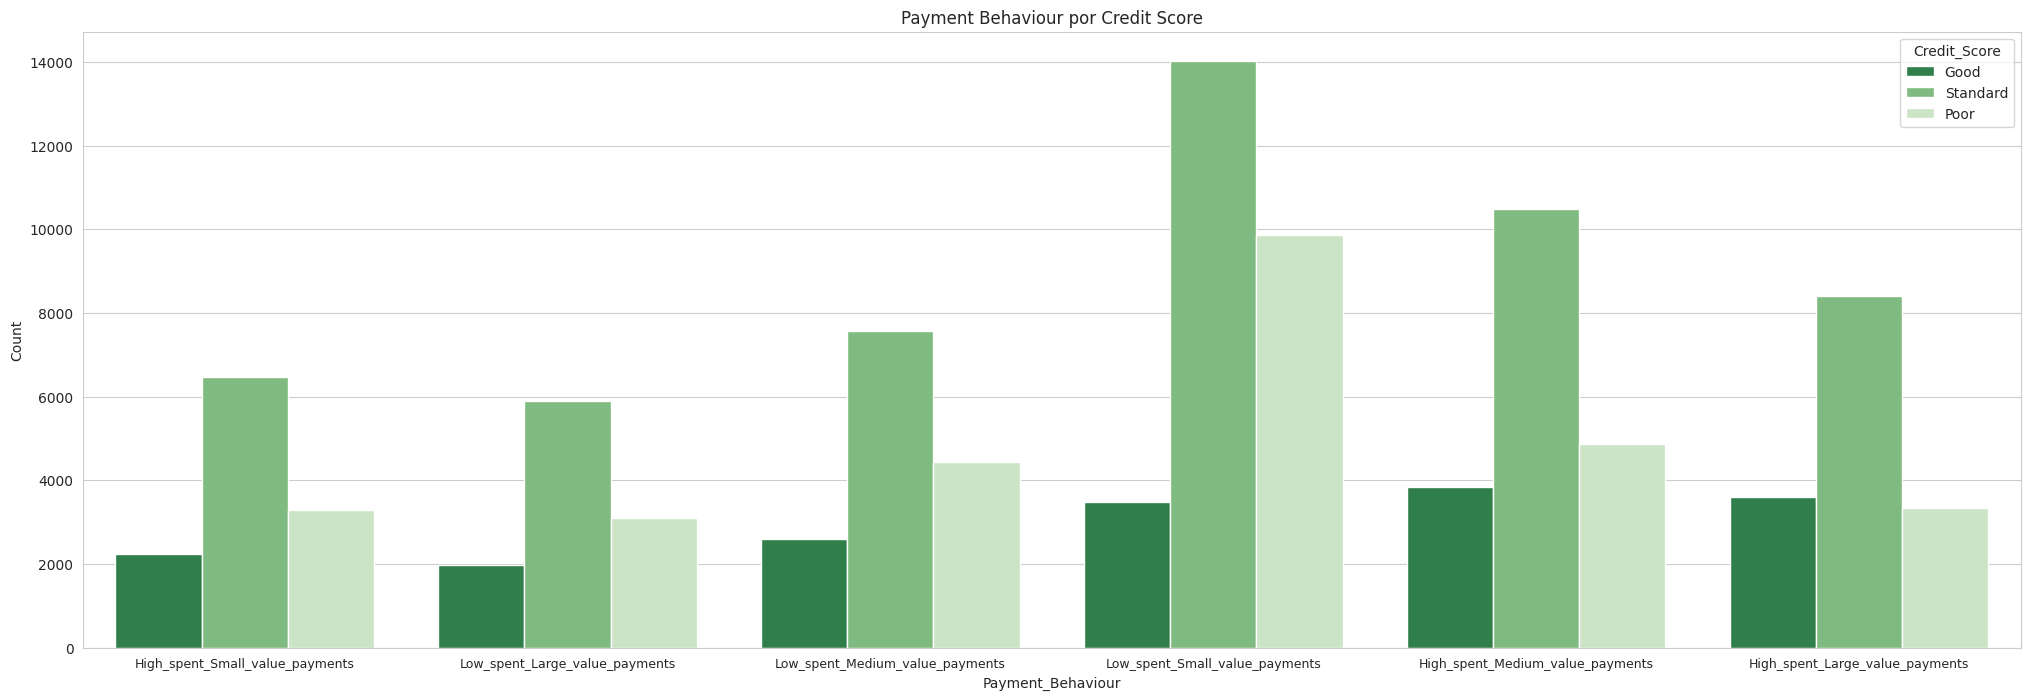

In [99]:
# Gráfico do Payment_Behaviour por Credit_Score
plt.figure(figsize=(25, 8))

ax = sns.countplot(x='Payment_Behaviour', hue='Credit_Score', data=df_total, palette='Greens_r')

# Título e colunas
plt.title('Payment Behaviour por Credit Score')
plt.xlabel('Payment_Behaviour')
plt.ylabel('Count')
plt.xticks(fontsize=9)

plt.show()

In [100]:
# Coluna Payment_of_Min_Amount
get_value_count(df_total, 'Payment_of_Min_Amount')

,Payment_of_Min_Amount,counts,percent
0,Yes,52024,52.33%
1,No,35466,35.67%
2,NM,11934,12.00%


In [101]:
# verifica valores nulos
print('Nulos:', df_total['Payment_of_Min_Amount'].isna().sum())

Nulos: 0


In [102]:
# Substituir os valores NM por NaN
df_total['Payment_of_Min_Amount'].replace('NM', np.nan, inplace=True)

In [103]:
print('Nulos:', df_total['Payment_of_Min_Amount'].isna().sum())

Nulos: 11934


In [104]:
# Usa as colunas correspondentes agrupadas e usa a moda da variavel alvo para substituir as Unknown
df_total.groupby(['Credit_Score','Outstanding_Debt','Num_of_Loan','Payment_Behaviour'])['Payment_of_Min_Amount'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

Credit_Score  Outstanding_Debt  Num_of_Loan  Payment_Behaviour               
Good          0.230             3            High_spent_Large_value_payments      No
                                             High_spent_Medium_value_payments     No
                                             Low_spent_Large_value_payments       No
                                             Low_spent_Medium_value_payments      No
                                             Low_spent_Small_value_payments       No
                                                                                ... 
Standard      4997.050          5            Low_spent_Medium_value_payments     Yes
              4997.100          6            Low_spent_Large_value_payments      Yes
                                             Low_spent_Small_value_payments      Yes
              4998.070          8            High_spent_Medium_value_payments    Yes
                                             High_spent_Small_value_payments     Yes
Name: Payment_of_Min_Amount, Length: 59785, dtype: object

In [105]:
df_total['Payment_of_Min_Amount'] = df_total.groupby(['Credit_Score','Outstanding_Debt','Num_of_Loan','Payment_Behaviour'])['Payment_of_Min_Amount'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [106]:
print('Nulos:', df_total['Payment_of_Min_Amount'].isna().sum())

Nulos: 0


In [107]:
get_value_count(df_total, 'Payment_of_Min_Amount')

,Payment_of_Min_Amount,counts,percent
0,Yes,56272,56.60%
1,No,38241,38.46%
2,Unknown,4911,4.94%


In [108]:
# Remove do dataset os valores Unknown por representarem apenas 5% dos dados
df_total = df_total[df_total['Payment_of_Min_Amount'] != 'Unknown']

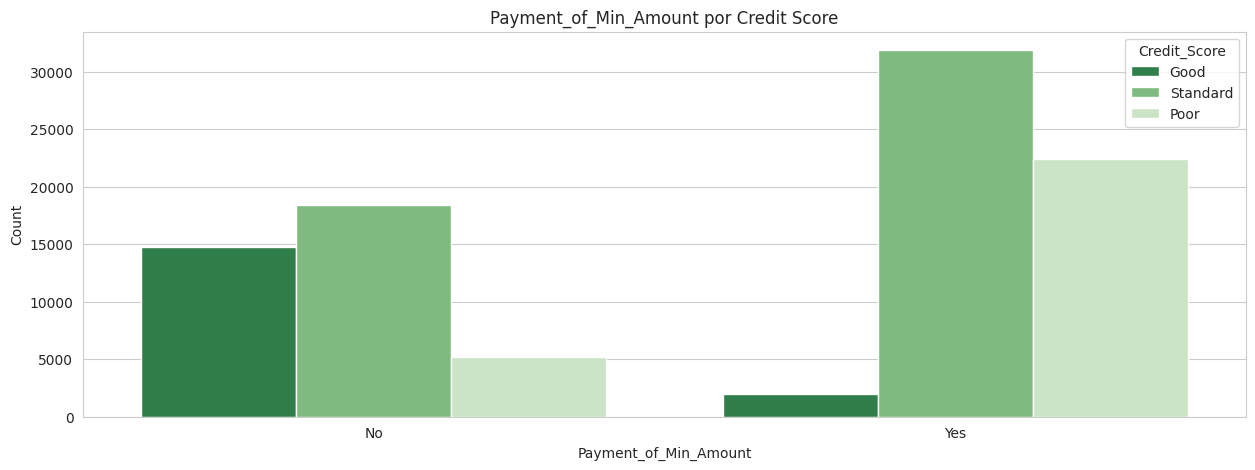

In [109]:
# Grafico do Payment_of_Min_Amount por Credit_Score
plt.figure(figsize=(15, 5))

ax = sns.countplot(x='Payment_of_Min_Amount', hue='Credit_Score', data=df_total, palette='Greens_r')

plt.title('Payment_of_Min_Amount por Credit Score')
plt.xlabel('Payment_of_Min_Amount')
plt.ylabel('Count')
plt.show()

In [110]:
# Coluna Total_EMI_per_month
get_value_count(df_total, 'Total_EMI_per_month')

,Total_EMI_per_month,counts,percent
0,0.000,10052,10.64%
1,113.146,8,0.01%
2,112.657,8,0.01%
3,64.441,8,0.01%
4,43.090,8,0.01%
...,...,...,...
14785,80357.000,1,0.00%
14786,33738.000,1,0.00%
14787,37602.000,1,0.00%
14788,62073.000,1,0.00%


In [111]:
# verifica valores nulos
print('Nulos:', df_total['Total_EMI_per_month'].isna().sum())

find_non_numeric_values(df_total, 'Total_EMI_per_month')

Nulos: 0


{' ', '.'}

In [112]:
# Coluna Credit_Score
get_value_count(df_total, 'Credit_Score')

,Credit_Score,counts,percent
0,Standard,50262,53.18%
1,Poor,27539,29.14%
2,Good,16712,17.68%


In [113]:
# verificar outliers
df_total.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Age,94513.000,34.343,9.786,18.000,26.000,34.000,42.000,56.000
Annual_Income,94513.000,168536.136,1386456.264,7005.930,19379.710,37353.580,72572.460,24198062.000
Monthly_Inhand_Salary,94513.000,5664.906,44994.056,303.645,1621.118,3085.853,5957.715,1990379.583
Num_Bank_Accounts,94513.000,17.124,117.652,0.000,3.000,6.000,7.000,1798.000
Num_Credit_Card,94513.000,22.576,129.431,0.000,4.000,5.000,7.000,1499.000
Interest_Rate,94513.000,72.293,466.108,1.000,8.000,13.000,20.000,5797.000
Num_of_Loan,94513.000,9.716,56.183,0.000,2.000,3.000,6.000,1496.000
Delay_from_due_date,94513.000,21.067,14.844,-5.000,10.000,18.000,28.000,67.000
Num_of_Delayed_Payment,94513.000,31.104,219.451,0.000,9.000,15.000,19.000,4397.000
Changed_Credit_Limit,94513.000,10.186,6.878,-6.490,4.980,9.270,14.700,36.970


In [114]:
df_total.describe(include='object').T

,count,unique,top,freq
ID,94513,94513,0x25fed,1
Customer_ID,94513,12500,CUS_0x1cdb,8
Month,94513,8,March,11838
Name,85055,10139,Stevex,41
SSN,94513,12501,#F%$D@*&8,5277
Occupation,94513,16,Unknown,6657
Credit_Mix,94513,4,Standard,34607
Payment_of_Min_Amount,94513,2,Yes,56272
Payment_Behaviour,94513,6,Low_spent_Small_value_payments,26464
Credit_Score,94513,3,Standard,50262


In [115]:
# Salvar o dataset limpo
df_total.to_csv('clean_client.csv', index=False)

In [116]:
# download
#from IPython.display import FileLink, display

#df_total = FileLink('clean_client.csv', result_html_prefix="Click here: ")

#display(df_total)

As colunas **ID, Customer_ID, Name, e SSN** não são úteis para tarefas de classificação e podem adicionar complexidade desnecessária ao modelo. Esses recursos de identificação não fornecem padrões ou informações para a **RNA** aprender e podem até levar a overfitting, em que o modelo memoriza valores únicos em vez de aprender padrões úteis.

Da mesma forma, a coluna **Month**, onde todos os valores são idênticos, não oferece nenhuma variação ou poder preditivo para o modelo. Como não reflete nenhum comportamento significativo, não ajudará a RNA a melhorar suas previsões.

In [117]:
columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']

# drop colunas
df_total.drop(columns=columns_to_drop, inplace=True)

In [118]:
# Vamos gerar o calculo do IQR

import cufflinks as cf
cf.go_offline()

# Seleciona as colunas numéricas
df_num = df_total.select_dtypes(include='number')

# calcula o IQR das colunas numéricas
iqr_values = df_num.apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

# define o valor maximo
iqr_max = 2000
selected_columns = iqr_values[iqr_values > iqr_max].index

# filtra as colunas selecionadas
df_filtered = df_num[selected_columns]

df_filtered.shape

(94513, 2)

In [119]:
"""
Calcula a assimetria (skewness) de cada coluna numérica.
A skewness mede a simetria da distribuição dos dados:
≈ 0: distribuição simétrica (como a normal).
> 0: assimetria à direita (cauda longa à direita).
< 0: assimetria à esquerda (cauda longa à esquerda).
"""
num_cols = df_total.select_dtypes('number').columns
skew_limit = 1
skew_cols = df_total[num_cols].skew().sort_values(ascending=False).to_frame('Skew')

skew_cols

,Skew
Monthly_Inhand_Salary,33.221
Num_of_Loan,17.975
Num_of_Delayed_Payment,14.809
Annual_Income,12.918
Num_Bank_Accounts,11.185
Num_Credit_Inquiries,9.834
Interest_Rate,9.037
Num_Credit_Card,8.423
Total_EMI_per_month,7.085
Amount_invested_monthly,4.416


No conjunto de dados, há valores discrepantes visíveis em atributos como Renda Anual e Salário Mensal Recebido.
Dada a natureza financeira dos dados, esses valores discrepantes podem representar variações legítimas nos perfis financeiros dos clientes.
Portanto, nenhuma ação imediata será tomada em relação a esses valores discrepantes.
Se necessário, após avaliar o desempenho do modelo, ajustes poderão ser considerados para aprimorar ainda mais os resultados.

In [120]:
# seleciona as colunas do tipo 'object'
df_total.select_dtypes(include=['object']).head()

,Occupation,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,Scientist,Unknown,No,High_spent_Small_value_payments,Good
1,Scientist,Good,No,Low_spent_Large_value_payments,Good
2,Scientist,Good,No,Low_spent_Medium_value_payments,Good
3,Scientist,Good,No,Low_spent_Small_value_payments,Good
4,Scientist,Good,No,High_spent_Medium_value_payments,Good


As seguintes colunas são adequadas para Codificação Ordinal:

Credit_Score:
Categorias como Bom, Padrão e Ruim têm uma ordem natural em termos de capacidade de crédito, tornando-as ideais para codificação ordinal.

Credit_Mix:
Categorias como Ruim, Padrão e Bom indicam os níveis de risco de crédito, tornando-as ideais para codificação ordinal.

Payment_of_Min_Amount:
Pode ser codificado como Não = 0, Sim = 1, pois pagar o valor mínimo regularmente pode indicar diferentes níveis de comportamento financeiro.

Payment_Behaviour:
A coluna representa uma progressão clara em termos de responsabilidade financeira. A mudança de Pagamentos_de_Pequeno_Valor_Baixo_Gastos para Pagamentos_de_Grande_Valor_Alto_Gastos_Reais reflete níveis crescentes de comprometimento financeiro e comportamento de pagamento responsável. Portanto, essa característica deve ser codificada ordinalmente, pois a ordem é significativa. Clientes que efetuam pagamentos de alto valor demonstram maior capacidade financeira e responsabilidade em comparação com aqueles com pagamentos de baixo valor, tornando esta coluna ideal para codificação ordinal.

Codificação One-Hot
A coluna "Ocupação" não é inerentemente ordinal, pois as categorias não têm uma classificação ou ordem específica, portanto, seria mais adequada para a Codificação One-Hot.

In [121]:
# aplicando a codificação ordinal na variável alvo

In [122]:
df_total['Credit_Score'].value_counts()

,count
Credit_Score,
Standard,50262
Poor,27539
Good,16712


In [123]:
# Define a ordem de categorias
credit_score_order = [['Poor', 'Standard', 'Good']]

# Cria o OrdinalEncoder para Credit_Score
ordinal_encoder = OrdinalEncoder(categories=credit_score_order, dtype=int)

# aplica ordinal encoding
df_total['Credit_Score'] = ordinal_encoder.fit_transform(df_total[['Credit_Score']])
df_total['Credit_Score'].value_counts()

,count
Credit_Score,
1,50262
0,27539
2,16712


In [124]:
df_bck = df_total

In [125]:
# isolar a variavel alvo

X = df_total.drop(columns ="Credit_Score")
y = df_total["Credit_Score"]

In [126]:
seed = 101
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

In [127]:
df_total['Credit_Mix'].value_counts()

,count
Credit_Mix,
Standard,34607
Good,22859
Unknown,19147
Bad,17900


In [128]:
df_total['Payment_Behaviour'].value_counts()

,count
Payment_Behaviour,
Low_spent_Small_value_payments,26464
High_spent_Medium_value_payments,18353
High_spent_Large_value_payments,14612
Low_spent_Medium_value_payments,13698
High_spent_Small_value_payments,11150
Low_spent_Large_value_payments,10236


In [129]:
df_total['Payment_of_Min_Amount'].value_counts()

,count
Payment_of_Min_Amount,
Yes,56272
No,38241


In [130]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Seleção das colunas para transformação ordinal
ordinal_features = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

# Colunas para transformação one-hot
onehot_features = ['Occupation']

# define a ordem
credit_mix_order = ['Bad', 'Standard', 'Good', 'Unknown']
payment_min_order = ['No', 'Yes']
payment_behaviour_order = ['Low_spent_Small_value_payments',
                           'Low_spent_Medium_value_payments',
                           'Low_spent_Large_value_payments',
                           'High_spent_Small_value_payments',
                           'High_spent_Medium_value_payments',
                           'High_spent_Large_value_payments']

ordinal_categories = [credit_mix_order, payment_min_order, payment_behaviour_order]

# Transformação
column_transformed = make_column_transformer(
    (OrdinalEncoder(categories=ordinal_categories, dtype=int, handle_unknown="use_encoded_value", unknown_value=-100), ordinal_features),
    (OneHotEncoder(handle_unknown="ignore", dtype=int), onehot_features),
    remainder='passthrough',
    verbose_feature_names_out=False)

In [131]:
# Aplica a colunas transformadas ao X e y

X_train_transformed = column_transformed.fit_transform(X_train) # Train data
X_val_transformed = column_transformed.transform(X_val)  # Validation test data

In [132]:
ordinal_features = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
for feature, categories in zip(ordinal_features, ordinal_categories):
    print(f"\nFeature: {feature}")
    for i, category in enumerate(categories):
        print(f"  {category} -> {i}")


Feature: Credit_Mix
  Bad -> 0
  Standard -> 1
  Good -> 2
  Unknown -> 3

Feature: Payment_of_Min_Amount
  No -> 0
  Yes -> 1

Feature: Payment_Behaviour
  Low_spent_Small_value_payments -> 0
  Low_spent_Medium_value_payments -> 1
  Low_spent_Large_value_payments -> 2
  High_spent_Small_value_payments -> 3
  High_spent_Medium_value_payments -> 4
  High_spent_Large_value_payments -> 5


In [133]:
features = column_transformed.get_feature_names_out()
features

array(['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour',
       'Occupation_Accountant', 'Occupation_Architect',
       'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer',
       'Occupation_Entrepreneur', 'Occupation_Journalist',
       'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Mechanic',
       'Occupation_Media_Manager', 'Occupation_Musician',
       'Occupation_Scientist', 'Occupation_Teacher', 'Occupation_Unknown',
       'Occupation_Writer', 'Age', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Credit-Builder Loan', 'Personal Loan',
       'Debt Consolidation Loan', 'Student Loan', 'Payday Loan'

In [134]:
# Reatribuir os recursos transformados aos dados do X_train
X_train = pd.DataFrame(X_train_transformed, columns=features, index=X_train.index)
X_train.head()

,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,...,Amount_invested_monthly,Monthly_Balance,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
93881,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,230.671,221.195,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
76421,1.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,258.380,186.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
44594,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,307.965,330.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
64148,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,631.316,110.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000
18770,2.000,0.000,3.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,298.584,217.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000


In [135]:
# Reatribuir os recursos transformados aos dados do X_teste
X_val = pd.DataFrame(X_val_transformed, columns=features, index=X_val.index)
X_val.head()

,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,...,Amount_invested_monthly,Monthly_Balance,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
30786,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,122.143,126.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000
77879,2.000,0.000,5.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,53.814,374.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000
27298,2.000,0.000,2.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,430.854,186.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
63268,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.484,254.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000
92383,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,637.413,245.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000


Muitos algoritmos (como redes neurais, KNN e SVM) desempenham melhor quando os dados estão normalizados.

Evita que variáveis com escalas muito diferentes (ex: salário vs. número de filhos) dominem a aprendizagem.

O algoritimo MinMaxScaler ele aprende os valores máximos e mínimos de cada coluna e atribui um valor correspondente dentro de um intervalo 0 e 1.

In [136]:
# transforma os dados para o intervalo [0, 1], mantendo a forma da distribuição original.
scaler = MinMaxScaler()

# normaliza os valores de X_train e X_val
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# converte em dataframe
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)

X_train.head(10)

,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,...,Amount_invested_monthly,Monthly_Balance,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,0.000,1.000,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.023,0.546,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
1,0.333,0.000,0.400,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.026,0.459,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.333,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.031,0.816,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
3,0.000,1.000,0.400,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.063,0.270,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000
4,0.667,0.000,0.600,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.030,0.536,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000
5,0.333,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.007,0.566,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000
6,0.667,0.000,0.400,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,1.000,0.546,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.333,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.005,0.360,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000
8,0.333,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.007,0.288,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
9,0.333,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.017,0.372,0.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000


SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica usada para lidar com o desequilíbrio de classes, gerando exemplos sintéticos para a classe minoritária. Ela deve ser aplicada apenas ao conjunto de treinamento, pois cria novos dados sintéticos que não devem ser usados ​​nos conjuntos de validação ou teste. O uso de SMOTE nesses conjuntos interferiria na avaliação do desempenho do modelo em dados reais e não observados.
Aumenta artificialmente a quantidade de amostras da classe minoritária para balancear o conjunto de dados antes de treinar o modelo.

In [137]:
y_train.value_counts()

,count
Credit_Score,
1,40209
0,22031
2,13370


In [138]:
X_train["Monthly_Balance"].unique()

array([0.54639058, 0.45905707, 0.81637717, 0.27047146, 0.53598015,
       0.56575682, 0.35980149, 0.28784119, 0.37220844, 0.76426799,
       0.73945409, 0.12158809, 0.22084367, 0.17866005, 0.46401985,
       0.37468983, 0.70719603, 0.88337469, 0.64516129, 0.98014888,
       0.46153846, 0.79156328, 0.6898263 , 0.91066998, 0.48138958,
       0.12903226, 0.33746898, 0.06203474, 0.23076923, 0.68734491,
       0.60297767, 0.04218362, 0.67990074, 0.56079404, 0.63523573,
       0.85359801, 0.05707196, 0.64019851, 0.33002481, 0.02233251,
       0.63771712, 0.8337469 , 0.73200993, 0.27791563, 0.38461538,
       0.26550868, 0.83622829, 0.2382134 , 0.20347395, 0.39205955,
       0.61538462, 0.30521092, 0.34987593, 0.19851117, 0.91315136,
       0.7866005 , 0.78163772, 0.39702233, 0.79652605, 0.38709677,
       0.43176179, 0.79404467, 0.60049628, 0.53349876, 0.93300248,
       0.42183623, 0.44913151, 0.57568238, 0.25806452, 0.49131514,
       0.27295285, 0.15880893, 0.07692308, 0.32258065, 0.80893

In [139]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=seed)

# aplica o smote as bases de treino
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apenas os dados de treino (X_train, y_train) são balanceados — o conjunto de validação (X_val, y_val) permanece intacto.
print("X_train shape :", X_train_smote.shape)
print("y_train shape :", y_train_smote.shape)
print("X_test shape :", X_val.shape)
print("y_test shape :", y_val.shape)

y_train_smote.value_counts()

X_train shape : (120627, 44)
y_train shape : (120627,)
X_test shape : (18903, 44)
y_test shape : (18903,)


,count
Credit_Score,
1,40209
2,40209
0,40209


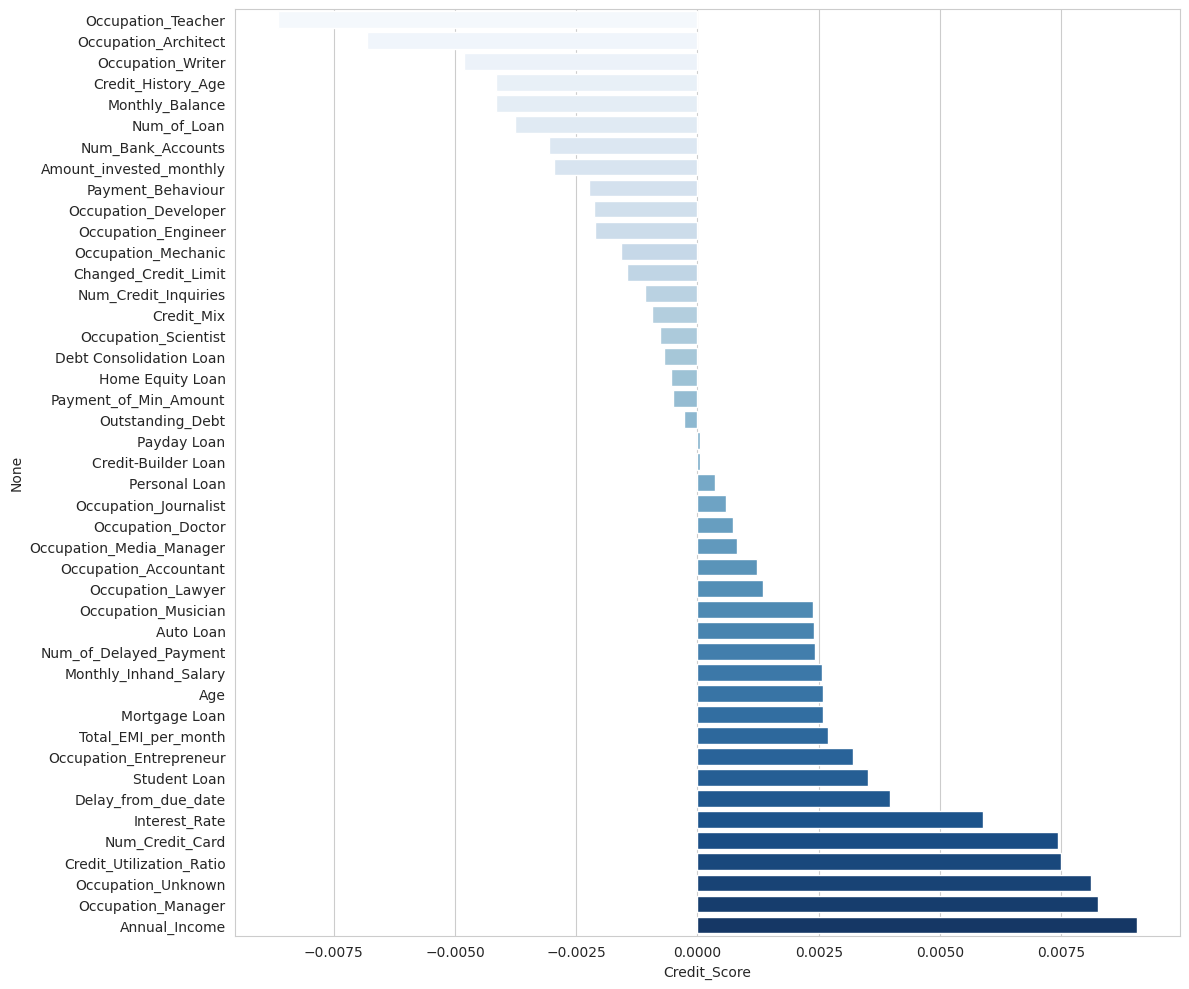

In [140]:
# Calcula a correlação com o Credit_Score
corr_by_target = X_train.join(y_train).corr()["Credit_Score"].sort_values()[:-1]

# Create the figure for the horizontal bar plot
plt.figure(figsize=(12, 10))
sns.barplot(x=corr_by_target, y=corr_by_target.index, palette='Blues')
plt.tight_layout()
plt.show()

Monthly Inhand Salary e Personal Loan têm o maior impacto positivo no Score de Crédito. Isso indica que indivíduos com maiores salários em caixa e empréstimos pessoais tendem a ter melhores scores de crédito.
As profissões Mechanic, Occupation Lawyer e Occupation Doctor apresentam impactos negativos, sugerindo que indivíduos nessas ocupações podem ter scores de crédito mais baixos ou menos influência em seus scores de crédito em comparação com outras características.
Características relacionadas ao comportamento financeiro, como Credit Utilization Ratio, Num of Delayed Payments, Outstanding Debt, e Annual Income, desempenham um papel significativo na determinação dos scores de crédito, com um efeito positivo.

In [141]:
# ########################## User-Defined-Function ###################################

# Função para avaliar o desempenho do modelo usando a classificação confusion_matrix()

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)

    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)

    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [142]:
#
def plot_feature_importances(model, X):
    """
    calcula a importância das variáveis de entrada (features) com base nos gradientes do
    modelo de rede neural do TensorFlow/Keras
    """
    # verifica de X é um dataframe e pega os nomes das colunas
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    else:
        raise ValueError("X é um dataframe")

    # converte o dataset para TensorFlow tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)

    # Calcula os gradientes do modelo sobre as saídas
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
    gradients = tape.gradient(predictions, X_tensor)

    # Calcular a importância dos recursos como a soma absoluta dos gradientes
    feature_importances = np.abs(gradients.numpy()).mean(axis=0)

    # Normanização
    feature_importances_percent = (feature_importances / feature_importances.sum()) * 100

    # Cria o dataframe e exibe a % da importância
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance (%)': feature_importances_percent.round(2)
    }).sort_values(by='Importance (%)', ascending=False)

    # Exibe em gráfico de barras a importância
    plt.figure(figsize=(18, 8))
    bars = plt.bar(importance_df['Feature'], importance_df['Importance (%)'])

    for bar, importance in zip(bars, importance_df['Importance (%)']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.1,
                 f'{importance:.2f}%', ha='center', va='bottom',rotation=90,fontsize=12)

    plt.xticks(rotation=90, ha='right',fontsize=12)
    plt.xlabel('Features')
    plt.ylabel('Importance (%)')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

Uma Rede Neural Artificial (RNA) é um modelo de aprendizado de máquina que imita a estrutura do cérebro humano para aprender padrões em dados. Ela consiste em camadas de nós interconectados (neurônios) que ajustam pesos para aprimorar as previsões.

Usamos RNA para este conjunto de dados porque ela consegue capturar relações complexas e não lineares entre características como pontuação de crédito, histórico de pagamentos e renda. Sua flexibilidade e capacidade de aprender com grandes quantidades de dados a tornam ideal para alcançar alta precisão neste conjunto de dados.

In [143]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

In [144]:
print('Credi_Score Classes before Smote: ', y_train.value_counts())
print('\nCredi_Score Classes after Smote: ', y_train_smote.value_counts())

Credi_Score Classes before Smote:  Credit_Score
1    40209
0    22031
2    13370
Name: count, dtype: int64

Credi_Score Classes after Smote:  Credit_Score
1    40209
2    40209
0    40209
Name: count, dtype: int64


In [145]:
"""
Construir uma rede neural robusta para classificar os dados após
balanceamento das classes com SMOTE, com arquitetura otimizada, regularização e técnicas de ajuste dinâmico de taxa de aprendizado.

1) Arquitetura do Modelo (Rede Neural - Sequential):
Dense(n): Camadas totalmente conectadas com n neurônios.
activation='relu': Função de ativação ReLU nas camadas ocultas (boa para redes profundas).
BatchNormalization(): Normaliza a saída da camada anterior — acelera e estabiliza o treinamento.
Dropout(p): Desliga aleatoriamente uma fração p dos neurônios durante o treino — evita overfitting.
Camada final Dense(3, activation='softmax'): 3 saídas (classificação multiclasse) com probabilidades.

2) Compilação do Modelo:
Adam: Otimizador eficiente com taxa de aprendizado adaptativa.
learning_rate=0.001: Taxa inicial de aprendizado.
sparse_categorical_crossentropy: Usado quando o alvo (y_train_smote) não está one-hot encoded.
metrics=['accuracy']: Avalia a acurácia durante o treino e validação.

3) Early Stopping:
Para evitar overfitting.
Interrompe o treinamento se val_accuracy não melhorar por 60 épocas.
restore_best_weights=True: Recupera os melhores pesos após a parada.

4) ReduceLROnPlateau:
Diminui automaticamente a taxa de aprendizado se o modelo não melhorar a val_loss.
factor=0.5: Reduz pela metade.
patience=10: Espera 10 épocas sem melhora.
min_lr=1e-6: Não permite que a taxa fique menor que isso.
Útil para "destravar" o modelo em platôs de aprendizado.

5) Treinamento do Modelo:
Usa os dados balanceados pelo SMOTE.
Divide os dados de validação para avaliar performance fora do treino.
batch_size=512: Atualiza os pesos a cada 512 amostras.
epochs=650: Número máximo de épocas, mas pode parar antes com EarlyStopping.
callbacks: Automatizam o ajuste da taxa de aprendizado e param o treinamento quando necessário.
"""

# 1) Arquitetura do Modelo (Rede Neural - Sequential):
ann7_smote = Sequential([
    Dense(512, input_dim=X_train_smote.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# 2) Compilação do Modelo:
ann7_smote.compile(optimizer=Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 3) Early Stopping:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=60,
                               mode="auto",
                               restore_best_weights=True)

# 4) ReduceLROnPlateau:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,  # Learning rate reduced by half if no improvement
                              patience=10,  # Wait 10 epochs before reducing learning rate
                              min_lr=1e-6,  # Minimum learning rate set
                              verbose=1)

# 5) Treinamento do Modelo:
history = ann7_smote.fit(
                    x=X_train_smote,
                    y=y_train_smote,
                    validation_data=(X_val, y_val),
                    batch_size=512,
                    epochs=650,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])  # Added ReduceLROnPlateau to callbacks

Epoch 1/650
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5654 - loss: 1.0269 - val_accuracy: 0.5605 - val_loss: 0.8947 - learning_rate: 0.0010
Epoch 2/650
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6790 - loss: 0.7874 - val_accuracy: 0.6201 - val_loss: 0.8480 - learning_rate: 0.0010
Epoch 3/650
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7039 - loss: 0.7387 - val_accuracy: 0.6394 - val_loss: 0.8203 - learning_rate: 0.0010
Epoch 4/650
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7144 - loss: 0.7123 - val_accuracy: 0.6540 - val_loss: 0.7870 - learning_rate: 0.0010
Epoch 5/650
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7187 - loss: 0.6967 - val_accuracy: 0.6571 - val_loss: 0.7895 - learning_rate: 0.0010
Epoch 6/650
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7238 - loss: 0.6830 - val_accuracy: 0.6574 - val_loss: 0.7896 - learning_rate: 0.0010
Epoch 7/650
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7288 - l

In [146]:
ann7_smote.evaluate(X_train_smote, y_train_smote)

3770/3770 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8591 - loss: 0.3410


[0.2594890892505646, 0.90097576379776]

In [147]:
ann7_smote.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,827 (2.27 MB)

 Trainable params: 197,635 (772.01 KB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 395,272 (1.51 MB)

In [148]:
eval_metric(ann7_smote, X_train_smote, y_train_smote, X_val, y_val)

3770/3770 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Set:
[[4546  744  218]
 [1590 6826 1637]
 [  74  482 2786]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      5508
           1       0.85      0.68      0.75     10053
           2       0.60      0.83      0.70      3342

    accuracy                           0.75     18903
   macro avg       0.73      0.78      0.74     18903
weighted avg       0.77      0.75      0.75     18903


Train Set:
[[38391  1348   470]
 [ 4593 30523  5093]
 [   42   399 39768]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     40209
           1       0.95      0.76      0.84     40209
           2       0.88      0.99      0.93     40209

    accuracy                           0.90    120627
   macro avg       0.91      0.90      0.90    120627
weighted avg       0.91      0.90      0.90    120627



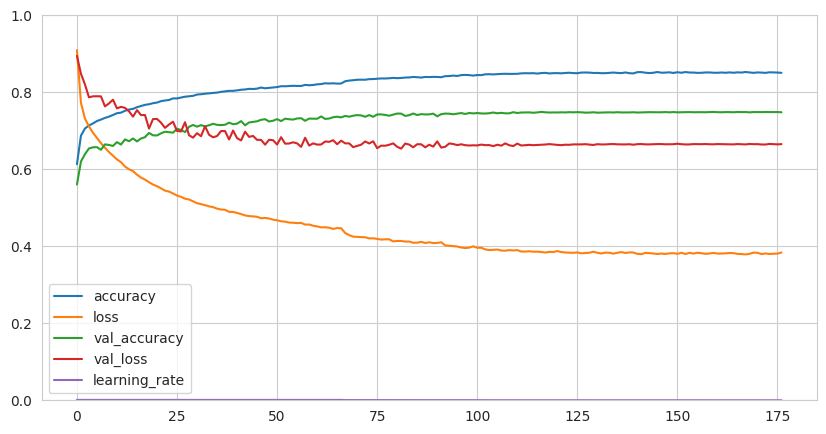

In [149]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

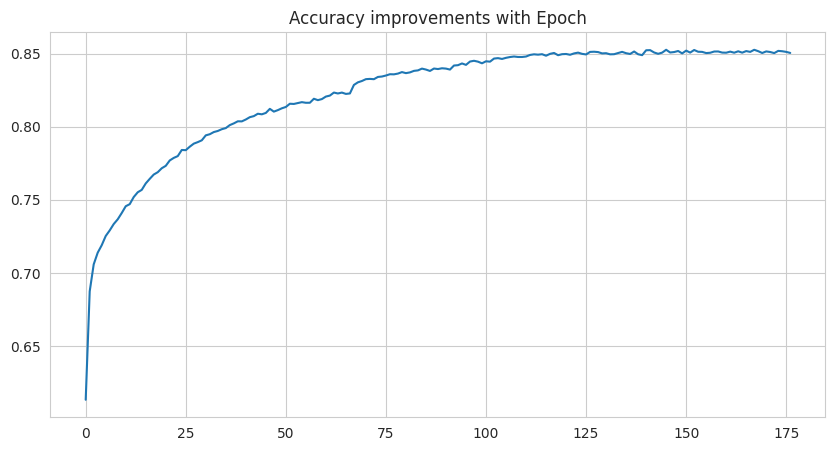

In [150]:
pd.DataFrame(history.history)["accuracy"].plot(figsize=(10, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

In [151]:
# Save the Model

from tensorflow.keras.models import load_model

# Save the model to 'model.h5' file
ann7_smote.save('ann7_smote_model.h5')

# To load the model later for further use
loaded_ann7_smote = load_model('ann7_smote_model.h5')

Resumo do Modelo ANN-7 com SMOTE:

Camadas (densas): 5 / Neurônios: 512-256-128-64 / Abandono: 30-30-25-20% / Taxa de Aprendizagem: 0,001, inicialmente reduzida para 1e-6 / Tamanho do Lote: 512 / Épocas: 650 / Parada Antecipada (val_accuracy): 60
Precisão: 0,91 / Val_Accuracy: 0,76 / Perda: 0,2938 / Val_Loss: 0,6628 / Recuperação do Trem (Classe 2): 0,99 / Recuperação do Teste (Classe 2): 0,84
Melhorias:

O modelo apresenta forte desempenho no conjunto de treinamento, com uma precisão de 0,91 e uma recuperação quase perfeita para a Classe 2, com 0,99. Isso indica alta sensibilidade à classe minoritária, aprimorada pelo SMOTE para equilibrar a distribuição de classes.
A adição do ReduceLROnPlateau gerenciou com eficácia os ajustes da taxa de aprendizado, contribuindo para manter a estabilidade do modelo ao longo do treinamento.
Sem Melhoria:

A precisão da validação mostra uma lacuna perceptível em comparação com a precisão do treinamento, indicando potencial sobreajuste ou a necessidade de ajustes adicionais no modelo para aprimorar sua generalização para dados não observados.
Apesar das métricas de treinamento robustas, o desempenho do conjunto de testes, especialmente em precisão e recall para determinadas classes, indica espaço para melhorias.
Piorou:

A perda de validação mostra leve variabilidade e permanece maior em comparação com a perda de treinamento, sugerindo que o modelo pode estar excessivamente ajustado aos dados de treinamento. Isso pode indicar a necessidade de ajustes adicionais nas taxas de abandono ou a possível exploração de técnicas alternativas de regularização.

In [152]:
#FINAL MODEL

# Transformando os dados de treino df_train e df_total!
X_transformed = column_transformed.fit_transform(X) # Train data

# Convertendo os resultados de volta para DataFrame
X = pd.DataFrame(X_transformed, columns=features, index=X.index)

In [153]:
X.head()

,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,...,Amount_invested_monthly,Monthly_Balance,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,3.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,80.415,265.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000
1,2.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,118.280,221.195,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000
2,2.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,81.700,267.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000
3,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,199.458,268.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000
4,2.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,41.420,269.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000


591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


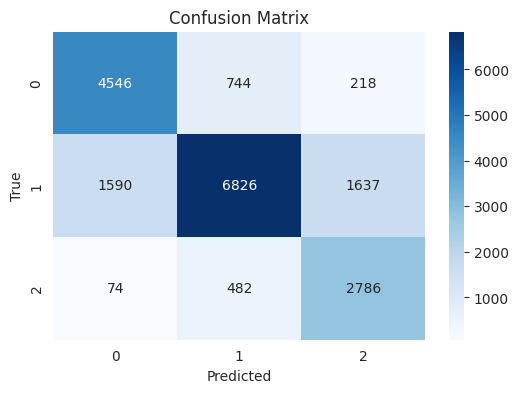

In [154]:
y_pred = ann7_smote.predict(X_val)
y_pred_classes  = y_pred.argmax(axis=1)

cm = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

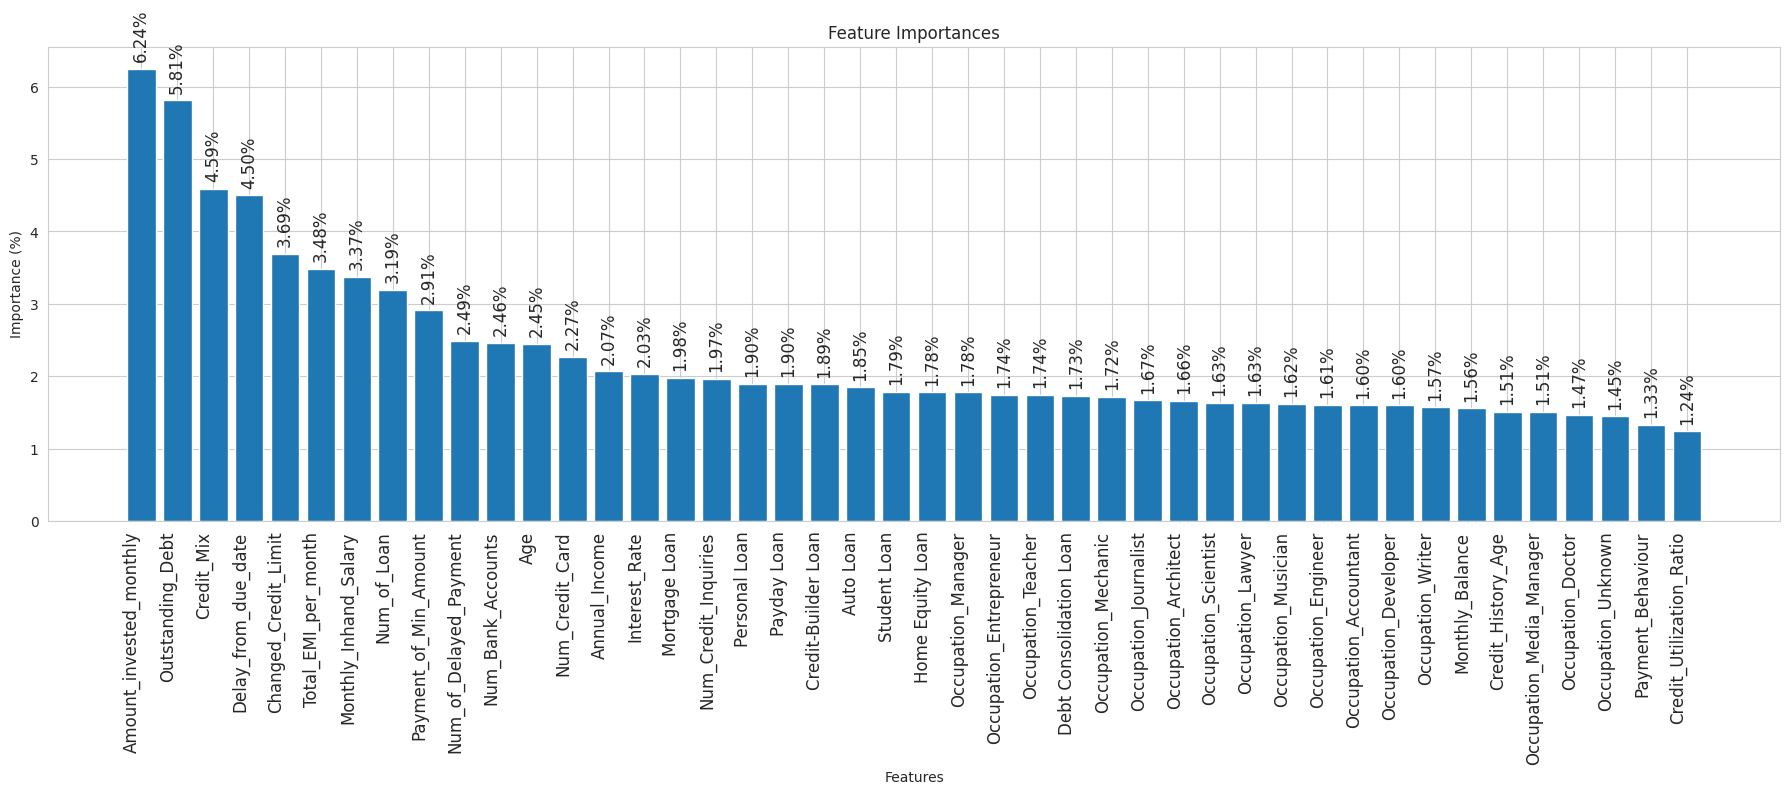

In [155]:
plot_feature_importances(ann7_smote, X_train)

In [157]:
# Load dataset
df_clean = pd.read_csv('clean_client.csv')

In [158]:
df_clean

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23.000,821-00-0265,Scientist,19114.120,1824.843,3,...,265.000,Good,1,1,0,0,0,0,1,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23.000,821-00-0265,Scientist,19114.120,1592.843,3,...,221.195,Good,1,1,0,0,0,0,1,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,35.000,821-00-0265,Scientist,19114.120,1592.843,3,...,267.000,Good,1,1,0,0,0,0,1,1
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23.000,821-00-0265,Scientist,19114.120,1592.843,3,...,268.000,Good,1,1,0,0,0,0,1,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23.000,821-00-0265,Scientist,19114.120,1824.843,3,...,269.000,Good,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94508,0x25fe9,CUS_0x942c,April,Nicks,25.000,078-73-5990,Mechanic,39628.990,3359.416,4,...,378.000,Poor,0,0,0,1,0,0,1,0
94509,0x25fea,CUS_0x942c,May,Nicks,25.000,078-73-5990,Mechanic,39628.990,3359.416,4,...,379.000,Poor,0,0,0,1,0,0,1,0
94510,0x25feb,CUS_0x942c,June,Nicks,25.000,078-73-5990,Mechanic,39628.990,3359.416,4,...,380.000,Poor,0,0,0,1,0,0,1,0
94511,0x25fec,CUS_0x942c,July,Nicks,25.000,078-73-5990,Mechanic,39628.990,3359.416,4,...,381.000,Standard,0,0,0,1,0,0,1,0


<Axes: xlabel='Month', ylabel='Monthly_Balance'>

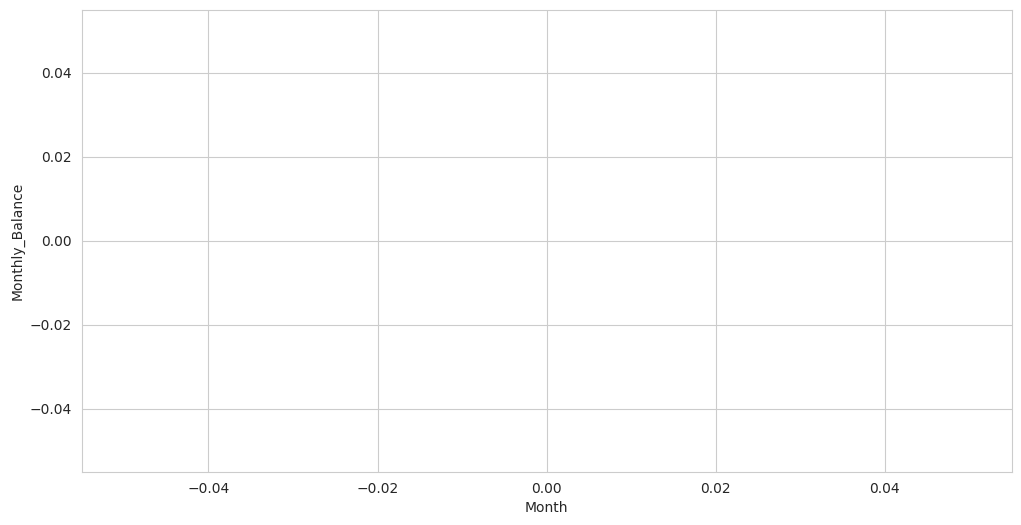

In [162]:
import seaborn as sns

df_clean = df_clean[df_clean['Customer_ID'] == 'CUS_0x942c']
sns.lineplot(data=df_clean, x='Month', y='Monthly_Balance')